## Implement the Gradient Log-Likelihood Attack (GLiR) on the trained models

In [1]:
import sys
sys.path.append("..")
import os
os.chdir("..")

In [2]:
import torchvision
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models

from opacus.grad_sample import GradSampleModule
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, ncx2
from torch.utils.data import TensorDataset, DataLoader

In [3]:
%load_ext autoreload
%autoreload 2

## 1. Simulated Gradients

For our first experiment, we use a simulated gradient distribution (Figure 2a of the paper). We instantiate a simualted model through the ```SimulatedGradientTracer``` class.

In [4]:
from gmip.glir import GaussianDataLoader
from gmip.glir import SimulatedGradientTracer, DirectGradients
from gmip.glir import GLiRAttack
from gmip.dp_sgd import recursive_fix
from gmip.utils import analytical_tpr

In [5]:
fs = np.linspace(0,1,100)
fs_log = np.exp(np.linspace(-12, 0, 100))
from scipy import interpolate
from sklearn.metrics import roc_curve
def interpolate_tprs(fprs, stats_lists):
    ts_rates = []
    for run in stats_lists:
        fs, ts, thresholds = roc_curve(run[1], -run[0], pos_label=1)
        f = interpolate.interp1d(fs, ts, fill_value=0)
        ts_rates.append(f(fprs))
    ts_rates = np.stack(ts_rates)
    return ts_rates

In [6]:
#params = {  #(d, n_avg) tuples
n_reps = 5
fs_use = np.linspace(0,1,100)
#params = {"purchase": (2560, 1970), "adult": (1026, 970), "cifar10": (650, 500)}
params = {"cifar10": (650, 500), "purchase": (2560, 1970), "adult": (1026, 970), "cifar10": (650, 500)}
ts_rates_all = {}
gradient_interface = DirectGradients()
for setup_name, (d, n_avg) in params.items():
    scores = [] # attack scores
    labels = [] # sample labels (in or out of train set)
    # To plot the curves until a FPR of 10^{-14] we need roughly 20k points.
    n_runs = n_runs = ((2000//n_avg)+1)
    for j in range(n_reps):
        rep_list = []
        print("Executing ", n_runs, "runs for", setup_name)
        for i in range(n_runs):
            out_scores = None
            while out_scores is None or np.isnan(out_scores).any(): # Catch NaN values due to underflow
                s = torch.randn(d,d)
                sigma = s.t() @ s
                gdl = GaussianDataLoader(mu = torch.zeros(d), Sigma=sigma, batch_size=n_avg)
                gdl_iter = iter(gdl)
                in_points = next(gdl_iter) # Points in the dataset
                out_points = next(gdl_iter) # Test points
                v_mean = torch.mean(in_points, axis=0)
                input_samples = torch.cat((in_points, out_points), axis=0)
                sim_tr = SimulatedGradientTracer(v_mean)
                attack = GLiRAttack(gdl, gradient_interface, sim_tr, d, n_avg)
                out_scores = attack.compute_glir_attack_scores(input_samples, batch_size=n_avg)
            scores.append(out_scores)
            labels.append(torch.ones(n_avg))
            labels.append(torch.zeros(n_avg))
        all_scores = torch.cat(scores)
        all_labels = torch.cat(labels)
        rep_list.append((all_scores, all_labels))
    ts_rates_all[setup_name] = interpolate_tprs(fs_use, rep_list)

Executing  5 runs for cifar10
Executing  5 runs for cifar10
Executing  5 runs for cifar10
Executing  5 runs for cifar10
Executing  5 runs for cifar10
Executing  2 runs for purchase
Executing  2 runs for purchase
Executing  2 runs for purchase
Executing  2 runs for purchase
Executing  2 runs for purchase
Executing  3 runs for adult
Executing  3 runs for adult
Executing  3 runs for adult
Executing  3 runs for adult
Executing  3 runs for adult


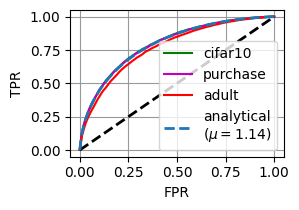

In [7]:
#ts_rates_all = torch.load("figures/grad_attack_rates1.pt")
colors = ["g", "m", "r"]
for setup_use, color_use in zip(ts_rates_all.keys(), colors):
    mean_rnd = np.mean(ts_rates_all[setup_use], axis=0)
    mean_rnd_std = np.std(ts_rates_all[setup_use], axis=0) # Standard error
    plt.fill_between(fs_use, mean_rnd-mean_rnd_std, mean_rnd+mean_rnd_std, color=color_use, alpha = 0.1)
    plt.plot(fs_use, mean_rnd, label = f"{setup_use}", color=color_use)  

plt.plot(fs_use, fs_use, "--k", linewidth=2)

plt.plot(fs_use, analytical_tpr(fs_use, 1.14), "--", color="tab:blue", label = "analytical\n($\mu=1.14$)", linewidth=2)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower right")
plt.grid(color='0.6')
plt.gcf().set_size_inches(3.0,2.2)
plt.tight_layout()

## 2. Real Gradients

We can now run the attack for real model gradients as shown in Figure 2b of the paper.

### Datasets and Loaders

First, we setup datasets and loaders for each of the 3 datasets used in our work.

In [8]:
# CIFAR 10
transform_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5070, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))])
cifar_train = torchvision.datasets.CIFAR10(root="datasets/", train=True, download=True, transform=transform_test)
cifar_test= torchvision.datasets.CIFAR10(root="datasets/", train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Purchase
import pandas as pd
import torch.utils.data as data

def base_csv_load(dataset):
    dataset_path = "datasets/"
    df = pd.read_csv(f"{dataset_path}{dataset}/{dataset}.csv", header=None)
    dataset_tensor = torch.tensor(df.values)
    labels = dataset_tensor[:, 0].long()
    features = dataset_tensor[:, 1:].float()

    # normalization
    features = (features-features.mean(axis=0))/(features.std(axis=0)+1e-5)
    return features, labels

dataset = "purchase"
features, labels = base_csv_load(dataset)
# splite in finetune and pretrain dataset
_, counts = torch.unique(labels, return_counts=True)
freq_ranks = torch.argsort(np.argsort(-counts))
#pretrain_dataset = freq_ranks[labels-1] >= 20
finetune_dataset = freq_ranks[labels-1] < 20
#labels_pretrain = labels.iloc[pretrain_dataset].values
#features_pretrain = features.iloc[pretrain_dataset].values
finetune_labels = labels[finetune_dataset]
finetune_features = features[finetune_dataset]
print(len(finetune_features), len(finetune_labels))
finetune_labels = freq_ranks[finetune_labels-1] # map labels from 0 -> 19.
test_data = 10000
x_test_pre, y_test = finetune_features[:test_data].float(),  finetune_labels[:test_data].long()
x_train_pre, y_train = finetune_features[test_data:].float(),  finetune_labels[test_data:].long()
# Create datasets
purchase_train = data.TensorDataset(x_train_pre, y_train)
purchase_test = data.TensorDataset(x_test_pre, y_test)

65494 65494


In [10]:
## Adult
dataset = "adult"
features, labels = base_csv_load(dataset)

test_data = 5000
x_test_pre, y_test = features[:test_data].float(),  labels[:test_data].long()
x_train_pre, y_train = features[test_data:].float(),  labels[test_data:].long()
# Create datasets
train_data_adult = data.TensorDataset(x_train_pre, y_train)
test_data_adult = data.TensorDataset(x_test_pre, y_test)

### Model construction for both datasets with pretrained weights.

In [11]:
from gmip.train_tabular import create_purchase_base, create_adult_base
from opacus.grad_sample import GradSampleModule
import torch.nn as nn
def load_cifar10_model():
    arch="resnet56"
    use_device = "cuda:0"
    ## Load empty model
    #model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_shufflenetv2_x0_5", pretrained=True)
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", f"cifar100_{arch}", pretrained=True)
    model = model.train()
    # some modifications of the model are necessary - replace batch norm layers
    recursive_fix(model)
    for p in model.parameters():
        p.requires_grad_(False)
    # adapt last layer to match CIFAR-10 output size
    in_feat = model.fc.in_features
    model.fc = torch.nn.Linear(in_feat, 10, bias=True)
    return GradSampleModule(model, loss_reduction = "mean"), lambda model, state: model.fc.load_state_dict(state)

def load_purchase_model():
    use_device = "cuda:0"
    model_finetune = create_purchase_base()[0].to(use_device)
    model_finetune.load_state_dict(torch.load("tabular/tabular_base998.pt"))
    ## Shut off dropout and change last layer.
    for p in model_finetune.parameters():
        p.requires_grad_(False)
    model_finetune[1].p=0.0
    model_finetune[4].p=0.0
    model_finetune[6] = nn.Linear(128, 20)
    return GradSampleModule(model_finetune, loss_reduction = "mean"), lambda model, state: model._module[6].load_state_dict(state)

def load_adult_model():
    use_device = "cuda:0"
    model_finetune = create_adult_base()[0].to(use_device)
    for p in model_finetune.parameters():
        p.requires_grad_(False)
    infeat = model_finetune[0].out_features
    model_finetune[2] = torch.nn.Linear(infeat, 2, bias=True)
    return GradSampleModule(model_finetune, loss_reduction = "mean"), lambda model, state: model._module.load_state_dict(state)

We first load and attack the models that were trained only for a single step using the corresponding training scripts ``cifar10/train_cifar_trace_grads.py`` or ``tabular/train_tabular.py`` with the tracegrad argument set to true.

In [12]:
from gmip.dp_sgd import RandomSubsetDataset
from gmip.glir import ClassificationModelGradients, CheckpointListTracer
from gmip.utils import ListDataLoader
## Set parameters for the gree datasets.
params_list = {"cifar10": {"data_train": cifar_train, "data_test": cifar_test, "model_load": load_cifar10_model,
                           "modelprefix": "models/CIFAR10_Cinf_tau0.0_batch500_ep1_resnet56_", "n_grad_estimations": 49500, "c": float("inf"),
                           "n": 500, "d": 650},
               "purchase": {"data_train": purchase_train, "data_test": purchase_test, "model_load": load_purchase_model,
                            "modelprefix": "models/purchase_Cinf_tau0.0_batch1970_ep1_", "n_grad_estimations": 53524, "c": float("inf"),
                           "n": 1970, "d": 2580},
               "adult": {"data_train": train_data_adult, "data_test": test_data_adult, "model_load": load_adult_model,
                            "modelprefix": "models/adult_Cinf_tau0.0_batch790_ep1_", "n_grad_estimations": 43000, "c": float("inf"),
                            "n": 970, "d": 1026}
              }


batch_size = 128
use_device = "cuda:0"
    
def run_glir_single_step(params_use, models_use = 5):
    # Load a model and set up the tracing
    tot_scores_list = []
    criterion = torch.nn.CrossEntropyLoss().to(use_device)
    for trained_model in range(models_use):
        # Create a model
        opacus_model, weight_load = params_use["model_load"]()
        opacus_model = opacus_model.to(use_device)
        
        print("Loading model no. ", trained_model)
        # Reset to a past training set that is loaded from a logfile
        tracer = CheckpointListTracer(f"{params_use['modelprefix']}{trained_model}_stepwise.pt", weight_load)
        #tracer.update_model_to_next_step(opacus_model)
        
        train_point_idx = tracer.get_used_sample_idx()
        n_in_out_points = len(train_point_idx)
        print("Number of train samples", n_in_out_points)
        
        # Create loaders for query points, background points, etc.
        # Background dataset: rest of the training data that was not used for test points
        val_dataset = RandomSubsetDataset(params_use["data_train"], subsample_ratio=1.0-(n_in_out_points/len(params_use["data_train"])))
        all_samples = torch.ones(len(params_use["data_train"]))
        all_samples[train_point_idx]=0 # set the used indices to zero.
        val_dataset.sample_idx = torch.where(all_samples==1)[0]
        background_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        ## Setup a trainpoints loader
        in_train_dataset = RandomSubsetDataset(params_use["data_train"], subsample_ratio=n_in_out_points/len(params_use["data_train"]))
        in_train_dataset.sample_idx = train_point_idx
        base_trainloader = torch.utils.data.DataLoader(in_train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        ## Setup loader of test points
        base_testloader = torch.utils.data.DataLoader(params_use["data_test"], batch_size=batch_size, shuffle=False, num_workers=4)
        
        train_test_loader = ListDataLoader(base_trainloader, base_testloader)
        
        gradient_comp = ClassificationModelGradients(opacus_model, criterion, cutoff_threshold = params_use["c"], device=use_device)
        attack = GLiRAttack(background_loader, gradient_comp, tracer, params_use["d"], params_use["n"])
        out_scores = attack.compute_glir_attack_scores_w_loader(train_test_loader, n_load=2*n_in_out_points)
        labels = torch.cat((torch.ones(n_in_out_points), torch.zeros(n_in_out_points)))
        tot_scores_list.append((out_scores, labels))
    return tot_scores_list

In [13]:
## Run the attacks on the model
fs_use = np.linspace(0,1,100)
ts_rates_all = {}
for dset in ["cifar10", "purchase", "adult"]:
    scores_list = run_glir_single_step(params_list[dset], models_use = 5)
    ts_rates_all[dset] = interpolate_tprs(fs_use, scores_list)

Using cache found in /home/dsar/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Loading model no.  0
Number of train samples 500
Using sub dataset of size 49500
Using sub dataset of size 500


/home/dsar/miniconda3/envs/opacus/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


switch to idx 1
Inverting Sigma...
Loading model no.  1
Number of train samples 500
Using sub dataset of size 49500
Using sub dataset of size 500


Using cache found in /home/dsar/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


switch to idx 1
Inverting Sigma...
Loading model no.  2
Number of train samples 500
Using sub dataset of size 49500
Using sub dataset of size 500


Using cache found in /home/dsar/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


switch to idx 1
Inverting Sigma...
Loading model no.  3
Number of train samples 500
Using sub dataset of size 49500
Using sub dataset of size 500


Using cache found in /home/dsar/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


switch to idx 1
Inverting Sigma...
Loading model no.  4
Number of train samples 500
Using sub dataset of size 49500
Using sub dataset of size 500


Using cache found in /home/dsar/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


switch to idx 1
Inverting Sigma...
Loading model no.  0
Number of train samples 1970
Using sub dataset of size 53524
Using sub dataset of size 1970


/home/dsar/miniconda3/envs/opacus/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


switch to idx 1
Inverting Sigma...
Loading model no.  1
Number of train samples 1970
Using sub dataset of size 53524
Using sub dataset of size 1970
switch to idx 1
Inverting Sigma...
Loading model no.  2
Number of train samples 1970
Using sub dataset of size 53524
Using sub dataset of size 1970
switch to idx 1
Inverting Sigma...
Loading model no.  3
Number of train samples 1970
Using sub dataset of size 53524
Using sub dataset of size 1970
switch to idx 1
Inverting Sigma...
Loading model no.  4
Number of train samples 1970
Using sub dataset of size 53524
Using sub dataset of size 1970
switch to idx 1
Inverting Sigma...
Loading model no.  0
Number of train samples 790
Using sub dataset of size 43052
Using sub dataset of size 790


/home/dsar/miniconda3/envs/opacus/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


switch to idx 1
Inverting Sigma...
Loading model no.  1
Number of train samples 790
Using sub dataset of size 43052
Using sub dataset of size 790
switch to idx 1
Inverting Sigma...
Loading model no.  2
Number of train samples 790
Using sub dataset of size 43052
Using sub dataset of size 790
switch to idx 1
Inverting Sigma...
Loading model no.  3
Number of train samples 790
Using sub dataset of size 43052
Using sub dataset of size 790
switch to idx 1
Inverting Sigma...
Loading model no.  4
Number of train samples 790
Using sub dataset of size 43052
Using sub dataset of size 790
switch to idx 1
Inverting Sigma...


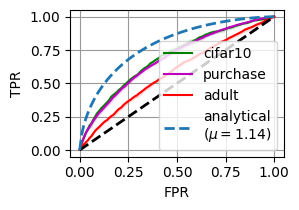

In [14]:
#ts_rates_all = torch.load("figures/grad_attack_rates1.pt")
colors = ["g", "m", "r"]
for setup_use, color_use in zip(ts_rates_all.keys(), colors):
    mean_rnd = np.mean(ts_rates_all[setup_use], axis=0)
    mean_rnd_std = np.std(ts_rates_all[setup_use], axis=0) # Standard error
    plt.fill_between(fs_use, mean_rnd-mean_rnd_std, mean_rnd+mean_rnd_std, color=color_use, alpha = 0.1)
    plt.plot(fs_use, mean_rnd, label = f"{setup_use}", color=color_use)  

plt.plot(fs_use, fs_use, "--k", linewidth=2)

plt.plot(fs_use, analytical_tpr(fs_use, 1.14), "--", color="tab:blue", label = "analytical\n($\mu=1.14$)", linewidth=2)
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.legend(loc="lower right")
plt.grid(color='0.6')
plt.gcf().set_size_inches(3.0,2.2)
plt.tight_layout()